In [61]:
import os
import sys
import warnings

Path = '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Code/'
if Path not in sys.path: sys.path.append(Path)
Path = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Code/'
if Path not in sys.path: sys.path.append(Path)
warnings.filterwarnings('ignore')
    
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from Dataset2 import ProcessingDatasetContainer



In [62]:
from FD_Reconstruction_Definitions import Get_Pixel_Pos_Dict_EBStyle

PixelPos = Get_Pixel_Pos_Dict_EBStyle()
def IndexToXY(indices):
    indices -=1
    Xs = indices//22
    Ys = indices%22
    return Ys.int().tolist(),Xs.int().tolist()


index = 440

print(PixelPos[index])
print(IndexToXY(torch.tensor([index])))

[0, 19]
([21], [19])


In [2]:
# Load Model and Tracker Here
Name = 'Model_1_3'
Model = torch.load(f'{Name}.pt')
Tracker = torch.load(f'{Name}_Tracker.pt')
print(Model.Description)


        Try to predict the SDP, 
        two parameters: Phi and Theta
        Introduction of Dropout Regularisation in order to allow for larger conv and dense layer sizes
        Also Add depth to the network with 2 more conv layers
        


In [5]:
# Import Dataset Here

datapath = '/remote/tychodata/ftairli/work/Projects/ProfileReconstruction/Data/'
Dataset = ProcessingDatasetContainer(datapath)

In [7]:
# Some Information
print(f'Final Epoch          : {len(Tracker.EpochLoss["Total"])}')
print(f'Final Loss           : {Tracker.EpochLoss["Total"][-1]}')
print(f'Final Validation Loss: {Tracker.EpochValLoss["Total"][-1]}')

Final Epoch          : 20
Final Loss           : 0.5281610884802846
Final Validation Loss: 0.5663294792175293


In [6]:
# Loss Plot
EpochLosses    = Tracker.EpochLoss
EpochValLosses = Tracker.EpochValLoss
Keys = list(EpochLosses.keys())
Nepochs = len(EpochLosses[Keys[0]])

ax = plt.figure(figsize=(20, 10)).gca()

# Define colors
colors = ['blue', 'orange', 'green', 'red','cyan']


custom_lines = []
custom_keys  = []
for i in range(len(Keys)):
    plt.plot(EpochLosses[Keys[i]]   , color=colors[i], label=Keys[i] + ' - Training')
    plt.plot(EpochValLosses[Keys[i]], color=colors[i], label=Keys[i] + ' - Validation', linestyle='dashed')
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=2))
    custom_keys.append(Keys[i]+' Loss')

custom_lines+= [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='dashed')]
custom_keys += ['Training', 'Validation']


ax.legend(custom_lines, custom_keys)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True)) # integer ticks
ax.set_title('Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.grid()

AttributeError: 'list' object has no attribute 'keys'

In [7]:
# Define some metrics
def MeanSquaredError(Truths,Predictions):
    return ((Truths-Predictions)**2).mean()
def MeanAbsoluteError(Truths,Predictions):
    return (np.abs(Truths-Predictions)).mean() if type(Truths) != torch.Tensor else (torch.abs(Truths-Predictions)).mean()
def Percentile68(Truths,Predictions):
    return np.percentile(np.abs(Truths-Predictions),68) if type(Truths) != torch.Tensor else torch.quantile(torch.abs(Truths-Predictions),0.68)

In [38]:
# Compute the Test Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



Dataset.State      = 'Test'
Dataset.BatchSize  = len(Dataset)//256
Dataset.RandomIter = False
Truth = []
Pred  = []
Rec   = []
Model.eval()
EvI = 0
with torch.no_grad():
    for EventIndex,BatchMains, BatchAux,BatchTruth,BatchRec in Dataset:
        # Send to device
        BatchMains = [Main.to(device) for Main in BatchMains]
        # Switch the last two dimensions
        BatchMains = BatchMains[0].transpose(3,2)
        BatchMains = BatchMains[:,(1,0),:,:]
        # print(BatchMains.shape)
        BatchAux   = BatchAux.to(device)
        

        ModelGuess , _ = Model(BatchMains, BatchAux)
        Truth .append(BatchTruth)
        Pred  .append(ModelGuess.cpu())
        Rec   .append(BatchRec)
        EvI+=1

Truth = torch.cat(Truth, dim=0)
Pred  = torch.cat(Pred , dim=0)
Rec   = torch.cat(Rec  , dim=0)

print(f'Pred Loss {MeanSquaredError(Truth,Pred)}')
print(f'Rec  Loss {MeanSquaredError(Truth,Rec )}')

Truth = Dataset.Unnormalise_Truth(Truth)
Pred  = Dataset.Unnormalise_Truth(Pred)
Rec   = Dataset.Unnormalise_Truth(Rec)

# drop NaN values
if True:
    Mask = ~torch.isnan(Truth[:,0]) & ~torch.isnan(Truth[:,1]) & ~torch.isnan(Pred[:,0]) & ~torch.isnan(Pred[:,1]) & ~torch.isnan(Rec[:,0]) & ~torch.isnan(Rec[:,1])
    print(f'Dropping {len(Truth) - Mask.sum()} NaN values')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]
    NanLocs = torch.where(Mask==0)
    print(f' Nan Locations {NanLocs}')

# Remove Bad events
if False:
    Mask = (torch.abs(Truth[:,0]-Rec[:,0]) < 1) & (torch.abs(Truth[:,1]-Rec[:,1]) < 1000)
    print(f'Dropping {len(Truth) - Mask.sum()} Bad events')
    Truth = Truth[Mask]
    Pred  = Pred [Mask]
    Rec   = Rec  [Mask]


Truth = Truth.numpy()
Pred  = Pred .numpy()
Rec   = Rec  .numpy()


print(Truth.shape)
print(Pred.shape)



Pred Loss 0.5856242179870605
Rec  Loss 0.00041094693006016314
Dropping 216 NaN values
 Nan Locations (tensor([   32,   165,   748,   948,  1593,  3173,  3191,  3293,  3827,  4034,
         5351,  6244,  6294,  6821,  7256,  8107,  8200,  9038,  9192, 10338,
        10953, 11090, 11414, 11802, 12187, 12240, 12283, 12864, 12991, 13231,
        13246, 13614, 13709, 13921, 14586, 15080, 15300, 15310, 15562, 15680,
        16421, 16514, 17051, 17949, 18202, 18466, 18884, 18890, 19506, 19672,
        19717, 19913, 20014, 20132, 20327, 20527, 20589, 20937, 21306, 21670,
        22077, 22767, 23198, 23559, 23836, 23849, 23907, 23922, 24502, 24997,
        25160, 25199, 25323, 25456, 25949, 26574, 26621, 27216, 27260, 28167,
        28299, 29329, 29637, 29841, 30538, 30791, 31026, 31402, 31422, 31909,
        31962, 31972, 32158, 32666, 32842, 33126, 33314, 33476, 33501, 34009,
        34144, 34431, 35310, 35315, 35451, 35474, 36167, 36169, 36745, 36873,
        36994, 37050, 37271, 37642, 3942

In [30]:
# Compute Metric
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

Pred68 = []
Rec68  = []

for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': 
        AngDivPred = np.arctan2(np.sin(Truth[:,i]-Pred[:,i]),np.cos(Truth[:,i]-Pred[:,i]))
        AngDivRec  = np.arctan2(np.sin(Truth[:,i]-Rec[:,i] ),np.cos(Truth[:,i]-Rec[:,i] ))
        Pred68.append(np.percentile(np.abs(AngDivPred),68))
        Rec68 .append(np.percentile(np.abs(AngDivRec ),68))
    elif TruthUnits[i] == 'deg':
        AngDivPred = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Pred[:,i])),np.cos(np.deg2rad(Truth[:,i]-Pred[:,i])))
        AngDivRec  = np.arctan2(np.sin(np.deg2rad(Truth[:,i]-Rec[:,i] )),np.cos(np.deg2rad(Truth[:,i]-Rec[:,i] )))
        Pred68.append(np.rad2deg(np.percentile(np.abs(AngDivPred),68)))
        Rec68 .append(np.rad2deg(np.percentile(np.abs(AngDivRec ),68)))
    else:
        Pred68.append(np.percentile(np.abs(Truth[:,i]-Pred[:,i]),68))
        Rec68 .append(np.percentile(np.abs(Truth[:,i]-Rec[:,i] ),68))

# Print Out the values
    
for i in range(len(TruthKeys)):
    if TruthUnits[i] == 'rad': # Convert to degrees
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]*180/np.pi:.5} deg')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] *180/np.pi:.5} deg')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')
        print()
    else:
        print(f'Adjusted Percentile for Pred {(TruthKeys[i]+"                          ")[:10]} {Pred68[i]:.5} {TruthUnits[i]}')
        print(f'Adjusted Percentile for Rec  {(TruthKeys[i]+"                          ")[:10]} {Rec68[i] :.5} {TruthUnits[i]}')
        print(f'Percentile Ratio   Pred/Rec             {Pred68[i]/Rec68[i]:.5}')


Adjusted Percentile for Pred SDPTheta   46.259 deg
Adjusted Percentile for Rec  SDPTheta   0.54914 deg
Percentile Ratio   Pred/Rec             84.238

Adjusted Percentile for Pred SDPPhi     68.46 deg
Adjusted Percentile for Rec  SDPPhi     0.19097 deg
Percentile Ratio   Pred/Rec             358.48



In [36]:
n=0
plt.scatter(Truth[:,n],Pred[:,2])
plt.plot([min(Truth[:, n]), max(Truth[:, n])], [min(Truth[:, n]), max(Truth[:, n])], 'r')

IndexError: index 2 is out of bounds for axis 1 with size 2

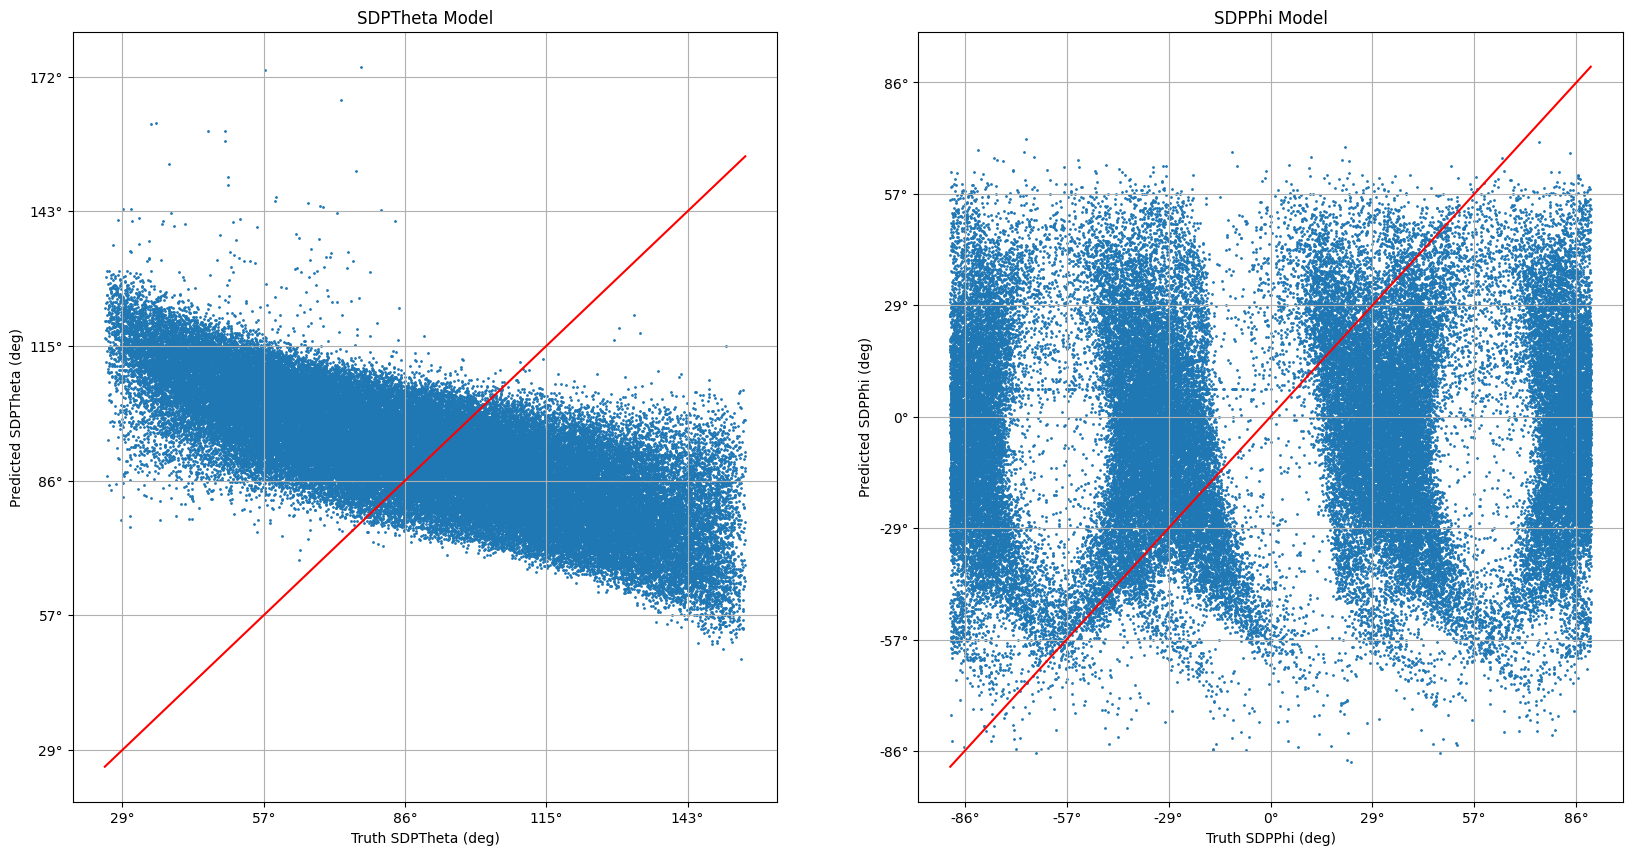

In [31]:
# Easy Scatter Plots of Predicted vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Pred[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Model')
    ax[i].grid()

plt.show()


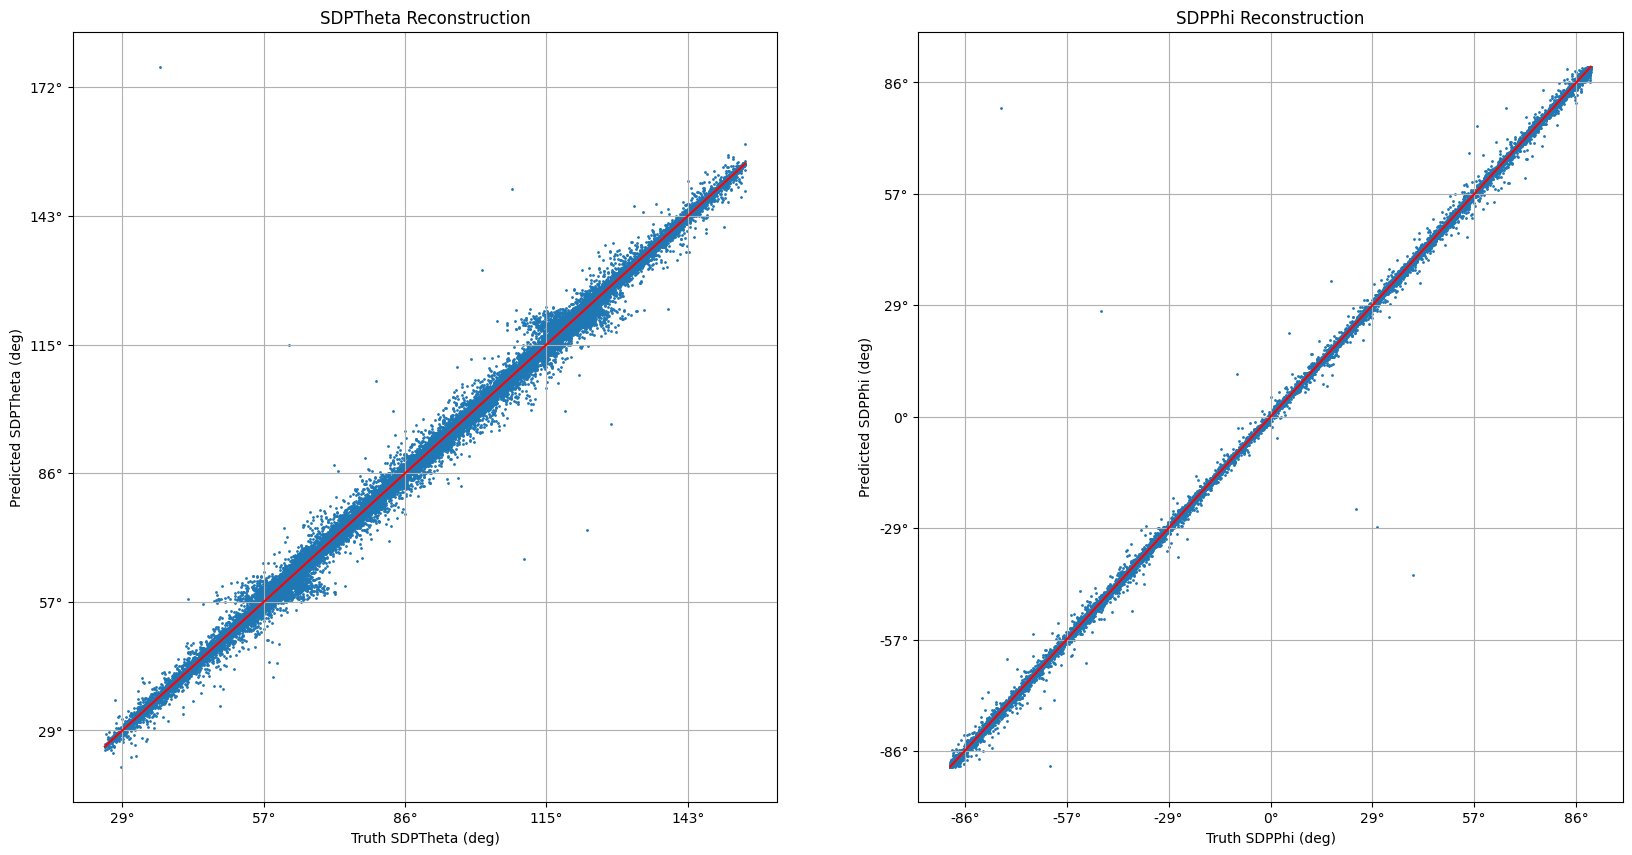

In [40]:
# Easy Scatter Plots of Reconstructed vs Truth
TruthKeys  = Dataset.Truth_Keys
TruthUnits = Dataset.Truth_Units

fig, ax = plt.subplots(1, len(TruthKeys), figsize=(10*len(TruthKeys), 10))

for i in range(len(TruthKeys)):
    ax[i].scatter(Truth[:, i], Rec[:, i], s=1)
    ax[i].plot([min(Truth[:, i]), max(Truth[:, i])], [min(Truth[:, i]), max(Truth[:, i])], 'r')
    if TruthUnits[i] == 'rad': # Change to degrees
        xticks = ax[i].get_xticks()
        ax[i].set_xticklabels([f"{x / np.pi * 180:.0f}°" for x in xticks])
        yticks = ax[i].get_yticks()
        ax[i].set_yticklabels([f"{y / np.pi * 180:.0f}°" for y in yticks])
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} (deg)')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} (deg)')
    else:
        ax[i].set_xlabel(f'Truth {TruthKeys[i]} ({TruthUnits[i]})')
        ax[i].set_ylabel(f'Predicted {TruthKeys[i]} ({TruthUnits[i]})')
    ax[i].set_title(f'{TruthKeys[i]} Reconstruction')
    ax[i].grid()

plt.show()
